In [1]:
import pandas as pd

acs_data = pd.read_csv(r"acs2017_census_tract_data.csv")

# Filter and select the required columns from the ACS data
selected_columns = ['County', 'State', 'TotalPop', 'IncomePerCap', 'Poverty']
acs_filtered = acs_data[selected_columns].copy()

# Create a new column 'ID' as a unique identifier for each row
acs_filtered['ID'] = range(len(acs_filtered))

# Group the data by 'County' and 'State' and aggregate the values using aggregation functions
aggregated_acs = acs_filtered.groupby(['County', 'State']).agg({
    'TotalPop': 'sum',
    'IncomePerCap': 'mean',
    'Poverty': 'mean'
})

# Reset the index of the aggregated DataFrame
county_info = aggregated_acs.reset_index()

# Rename the columns to match the desired column names
county_info.rename(columns={
    'County': 'county',
    'TotalPop': 'Population',
    'IncomePerCap': 'PerCapitaIncome'
}, inplace=True)

# Reset the 'ID' column to start from 1
county_info['ID'] = county_info.index + 1


county_inputs = [
    "Loudoun County, Virginia",
    "Washington County, Oregon",
    "Harlan County, Kentucky",
    "Malheur County, Oregon"
]


selected_counties = pd.DataFrame(columns=county_info.columns)

# Iterate over the list of county inputs and extract the corresponding details
for county_input in county_inputs:
    county_name, state_name = county_input.split(", ")
    county_details = county_info[(county_info['county'] == county_name) & (county_info['State'] == state_name)]
    selected_counties = pd.concat([selected_counties, county_details], ignore_index=True)

print(selected_counties)


              county     State Population  PerCapitaIncome    Poverty    ID
0     Loudoun County  Virginia     374558     50391.015625   3.884375  1760
1  Washington County    Oregon     572071     34970.817308  10.446154  3047
2      Harlan County  Kentucky      27548     16010.363636  33.318182  1235
3     Malheur County    Oregon      30421     17966.428571  24.414286  1823


In [15]:
import pandas as pd

# Load the COVID-19 data from a CSV file
covid_df = pd.read_csv(r"COVID_county_data.csv")

# Create a unique identifier for each county-state combination
covid_df['ID'] = covid_df['county'] + '_' + covid_df['state']
covid_df['ID'] = pd.factorize(covid_df['ID'])[0] + 1

# Convert the 'date' column to datetime format
covid_df['date'] = pd.to_datetime(covid_df['date'], format='%Y-%m-%d')

# Extract the month from the 'date' column
covid_df['month'] = covid_df['date'].dt.to_period('M')

# Group the data by 'ID' and 'month' and aggregate the values
covid_monthly = covid_df.groupby(['ID', 'month']).agg({
    'cases': 'sum',
    'deaths': 'sum',
    'county': 'first'
}).reset_index()

# Reset the 'ID' column to start from 1 for the monthly data
covid_monthly['ID'] = range(1, len(covid_monthly) + 1)
covid_monthly = covid_monthly[['ID', 'month', 'cases', 'deaths', 'county']].copy()

# Rename columns to match desired format
covid_monthly.columns = ['ID', 'Month', 'Cases', 'Deaths', 'County']

# Specify the months and county for the report
selected_months = ['2020-08', '2021-01', '2021-02']
selected_county_name = 'Malheur'

# Filter the monthly data for the selected county and months
covid_report_df = covid_monthly[
    (covid_monthly['County'] == selected_county_name) &
    (covid_monthly['Month'].astype(str).isin(selected_months))
]

print(covid_report_df)

# Summarize total cases and deaths by 'ID'
covid_summary_df = covid_monthly.groupby("ID").agg({
    "Cases": "sum",
    "Deaths": "sum"
}).reset_index()

# Rename columns for clarity
covid_summary_df.rename(columns={"Cases": "TotalCases", "Deaths": "TotalDeaths"}, inplace=True)

# Merge the summary with county information
covid_summary_df = pd.merge(covid_summary_df, county_info, how="left", on="ID")

# Calculate cases and deaths per 100,000 population
def getTotalCasesPer100K(row):
    total_population = row['Population'] / 100000
    if pd.notnull(total_population) and total_population > 0:
        return row['TotalCases'] / total_population
    return 0

def getTotalDeathsPer100K(row):
    total_population = row['Population'] / 100000
    if pd.notnull(total_population) and total_population > 0:
        return row['TotalDeaths'] / total_population
    return 0

covid_summary_df['TotalCasesPer100K'] = covid_summary_df.apply(getTotalCasesPer100K, axis=1)
covid_summary_df['TotalDeathsPer100K'] = covid_summary_df.apply(getTotalDeathsPer100K, axis=1)

# List of counties and states to filter
county_state_list = [
    ('Washington County', 'Oregon'),
    ('Malheur County', 'Oregon'),
    ('Loudoun County', 'Virginia'),
    ('Harlan County', 'Kentucky')
]

# Filter the summary DataFrame based on the specified counties
filtered_covid_df = covid_summary_df[
    (covid_summary_df['county'].isin([county[0] for county in county_state_list])) &
    (covid_summary_df['State'].isin([county[1] for county in county_state_list]))
]

# Extract the 'Poverty' and 'TotalCasesPer100K' values for the specified counties
poverty_percentage = filtered_covid_df[['county', 'State', 'Poverty']]
cases_per_100k_data = filtered_covid_df[['county', 'State', 'TotalCasesPer100K']]

# Print the results
print("Poverty Percentage:")
print(poverty_percentage)
print("\nTotal Cases per 100K:")
print(cases_per_100k_data)


          ID    Month  Cases  Deaths   County
25593  25594  2020-08  28163   459.0  Malheur
25598  25599  2021-01  96297  1627.0  Malheur
25599  25600  2021-02  65951  1137.0  Malheur
Poverty Percentage:
                 county     State    Poverty
1234      Harlan County  Kentucky  33.318182
1759     Loudoun County  Virginia   3.884375
1822     Malheur County    Oregon  24.414286
3035  Washington County  Kentucky  16.900000
3046  Washington County    Oregon  10.446154
3053  Washington County  Virginia  14.715385

Total Cases per 100K:
                 county     State  TotalCasesPer100K
1234      Harlan County  Kentucky      747727.60273
1759     Loudoun County  Virginia       666505.58792
1822     Malheur County    Oregon       1.491187e+06
3035  Washington County  Kentucky       1.788649e+05
3046  Washington County    Oregon       377110.358679
3053  Washington County  Virginia       5.508934e+01


In [6]:
import pandas as pd

# Filter the summary DataFrame for Oregon state
oregon_counties_df = covid_summary_df[covid_summary_df['State'] == 'Oregon']
# COVID total cases vs. % population in poverty
total_cases_vs_poverty_corr = oregon_counties_df['TotalCases'].corr(oregon_counties_df['Poverty'])
print(total_cases_vs_poverty_corr)

# COVID total deaths vs. % population in poverty
total_deaths_vs_poverty_corr = oregon_counties_df['TotalDeaths'].corr(oregon_counties_df['Poverty'])
print(total_deaths_vs_poverty_corr)

# COVID total cases vs. Per Capita Income level
total_cases_vs_income_corr = oregon_counties_df['TotalCases'].corr(oregon_counties_df['PerCapitaIncome'])
print(total_cases_vs_income_corr)

# COVID total deaths vs. Per Capita Income level
total_deaths_vs_income_corr = oregon_counties_df['TotalDeaths'].corr(oregon_counties_df['PerCapitaIncome'])
print(total_deaths_vs_income_corr)

# Overall analysis for all counties
# COVID total cases vs. % population in poverty
overall_cases_vs_poverty_corr = covid_summary_df['TotalCases'].corr(covid_summary_df['Poverty'])
print(overall_cases_vs_poverty_corr)

# COVID total deaths vs. % population in poverty
overall_deaths_vs_poverty_corr = covid_summary_df['TotalDeaths'].corr(covid_summary_df['Poverty'])
print(overall_deaths_vs_poverty_corr)

# COVID total cases vs. Per Capita Income level
overall_cases_vs_income_corr = covid_summary_df['TotalCases'].corr(covid_summary_df['PerCapitaIncome'])
print(overall_cases_vs_income_corr)

# COVID total deaths vs. Per Capita Income level
overall_deaths_vs_income_corr = covid_summary_df['TotalDeaths'].corr(covid_summary_df['PerCapitaIncome'])
print(overall_deaths_vs_income_corr)


0.05448687198634776
-0.003927649458842
-0.2557187510018219
-0.2878717772723963
0.02172395775348989
0.00988447825942164
-0.02544712849260708
-0.01255471625709621


In [7]:
# Overall analysis for all counties
# COVID total cases vs. % population in poverty (All counties)
overall_cases_vs_poverty_corr = covid_summary_df['TotalCases'].corr(covid_summary_df['Poverty'])
print("All Counties - Total Cases and Poverty Correlation:", overall_cases_vs_poverty_corr)

# COVID total deaths vs. % population in poverty (All counties)
overall_deaths_vs_poverty_corr = covid_summary_df['TotalDeaths'].corr(covid_summary_df['Poverty'])
print("All Counties - Total Deaths and Poverty Correlation:", overall_deaths_vs_poverty_corr)

# COVID total cases vs. Per Capita Income level (All counties)
overall_cases_vs_income_corr = covid_summary_df['TotalCases'].corr(covid_summary_df['PerCapitaIncome'])
print("All Counties - Total Cases and Per Capita Income Correlation:", overall_cases_vs_income_corr)

# COVID total deaths vs. Per Capita Income level (All counties)
overall_deaths_vs_income_corr = covid_summary_df['TotalDeaths'].corr(covid_summary_df['PerCapitaIncome'])
print("All Counties - Total Deaths and Per Capita Income Correlation:", overall_deaths_vs_income_corr)

All Counties - Total Cases and Poverty Correlation: 0.02172395775348989
All Counties - Total Deaths and Poverty Correlation: 0.00988447825942164
All Counties - Total Cases and Per Capita Income Correlation: -0.02544712849260708
All Counties - Total Deaths and Per Capita Income Correlation: -0.01255471625709621


In [9]:
import pandas as pd

# Filter the summary DataFrame for Oregon state
oregon_counties_df = covid_summary_df[covid_summary_df['State'] == 'Oregon']

# For Oregon Counties only: correlation between % poverty and COVID cases
oregon_poverty_cases_corr = oregon_counties_df['Poverty'].corr(oregon_counties_df['TotalCases'])
print("Oregon Counties - % Poverty and COVID Cases Correlation:", oregon_poverty_cases_corr)

# For all counties: correlation between population and COVID cases
population_cases_corr = covid_summary_df['Population'].corr(covid_summary_df['TotalCases'])
print("All Counties - Population and COVID Cases Correlation:", population_cases_corr)


# For Oregon counties only: correlation between Per Capita Income and COVID deaths
oregon_income_deaths_corr = oregon_counties_df['PerCapitaIncome'].corr(oregon_counties_df['TotalDeaths'])
print("Oregon Counties - Per Capita Income and COVID Deaths Correlation:", oregon_income_deaths_corr)

# For all USA counties: correlation between Per Capita Income and COVID cases
income_cases_corr = covid_summary_df['PerCapitaIncome'].corr(covid_summary_df['TotalCases'])
print("All USA Counties - Per Capita Income and COVID Cases Correlation:", income_cases_corr)

# For all counties: Correlation between Total Population and COVID deaths
population_deaths_corr = covid_summary_df['Population'].corr(covid_summary_df['TotalDeaths'])
print("All Counties - Population and COVID Deaths Correlation:", population_deaths_corr)

Oregon Counties - % Poverty and COVID Cases Correlation: 0.05448687198634775
All Counties - Population and COVID Cases Correlation: -0.008609434554935935
Oregon Counties - Per Capita Income and COVID Deaths Correlation: -0.2878717772723963
All USA Counties - Per Capita Income and COVID Cases Correlation: -0.02544712849260708
All Counties - Population and COVID Deaths Correlation: -0.0018662678699585796


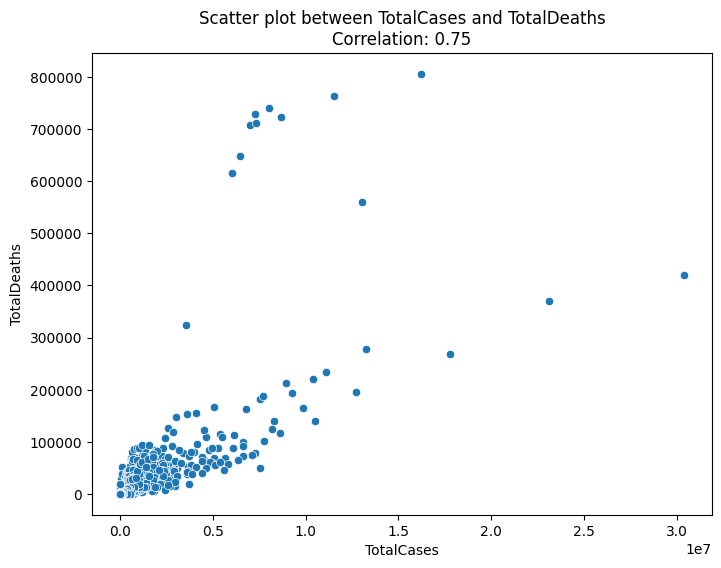

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation matrix
numeric_df = covid_summary_df.select_dtypes(include=[float, int])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Filter correlations greater than 0.5 or less than -0.5
strong_correlations = correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)]

# Remove self-correlations
strong_correlations = strong_correlations[strong_correlations != 1.0]

# Flatten the matrix and drop NaN values
strong_correlations = strong_correlations.stack().reset_index()
strong_correlations.columns = ['Variable1', 'Variable2', 'Correlation']
strong_correlations = strong_correlations.dropna()

# Plot scatter plot for the first strong correlation found
plotted = False
for index, row in strong_correlations.iterrows():
    var1 = row['Variable1']
    var2 = row['Variable2']
    correlation = row['Correlation']

    if abs(correlation) > 0.5:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=covid_summary_df, x=var1, y=var2)
        plt.title(f'Scatter plot between {var1} and {var2}\nCorrelation: {correlation:.2f}')
        plt.xlabel(var1)
        plt.ylabel(var2)
        plt.show()
        plotted = True
        break

if not plotted:
    print("No strong correlations found with |R| > 0.5.")
